# Winds Measured at Ship Compared to Nearby Buoy

## Example for Ocean Observatories Initiative Irminger Sea Cruise and Buoy turn from Deployment 10 to 11

Abstract:

### Preconditions:

- Imput files that for ship MET data



### Imput files:
- Ship MET.csv files
- Ship MET.txt files

### Output

- Plots used for inspections along with well writen workflow
- Hourly plot of Ship and Buoy sensors with standard deviation for comparisons

In [1]:
# Import the necessary packages
import os
import numpy as np
import pandas as pd
import xarray as xr
import csv
from os import path
# Import typing for function docstrings
import typing
from typing import Union, Tuple, List
import numpy.typing as npt

### Load the ship met data
I wrote a module of functions (the underway.py file) to parse and load the underway data. So we'll import those functions and use them to get the data into a nice dataset

In [2]:
from underway import *

In [3]:
# Enter in the directory you like the file to be located.
ship_dir = "/Users/aaron.wickware/Documents/PEP2024/Irminger_Sea-11/Irminger_Sea-11"
ship_met_files = sorted(["/".join((ship_dir, x)) for x in os.listdir(ship_dir) if x.endswith('.csv')])
met_headers = ["/".join((ship_dir, x)) for x in os.listdir(ship_dir) if 'MET_X' in x]
par_header = "/".join((ship_dir, 'MET_PAR.txt'))
rad_header = "/".join((ship_dir, 'MET_RAD.txt'))

# Parse the underway data
underway = parse_ship_met_data(ship_met_files, ATTRS, met_headers=met_headers, par_header=par_header, rad_header=rad_header)
underway

C:\Users\aaron.wickware\Documents\PEP2024\underway.py:272: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(' NAN', np.nan).replace(' NODATA', np.nan)


<xarray.Dataset>
Dimensions:                            (time: 10272)
Coordinates:
  * time                               (time) datetime64[ns] 2024-06-02T00:00...
Data variables: (12/36)
    latitude                           (time) float64 41.52 41.52 ... 59.93
    longitude                          (time) float64 -70.67 -70.67 ... -39.36
    ship_speed                         (time) float64 nan nan nan ... 0.01 -0.04
    heading                            (time) float64 25.76 25.8 ... 109.1 110.0
    DPS_COG                            (time) float64 278.3 59.06 ... 103.8
    speed_over_ground                  (time) float64 0.02 0.01 ... 0.29 0.24
    ...                                 ...
    sea_surface_temperature            (time) float64 17.03 17.02 ... 6.845
    speed_of_sound                     (time) float64 1.473e+03 ... 1.478e+03
    depth12                            (time) float64 nan nan nan ... nan nan
    depth35                            (time) float64 nan nan nan ... nan nan
    em122                              (time) float64 nan nan nan ... nan nan
    EM710                              (time) float64 nan nan nan ... nan nan

In [4]:
met_headers

['/Users/aaron.wickware/Documents/PEP2024/Irminger_Sea-11/Irminger_Sea-11/MET_XTP.txt',
 '/Users/aaron.wickware/Documents/PEP2024/Irminger_Sea-11/Irminger_Sea-11/MET_XTS.txt']

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
colors = ['#377eb8','#ff7f00','#FFC20A','#00ffff','#CC79A7','#4B0092']

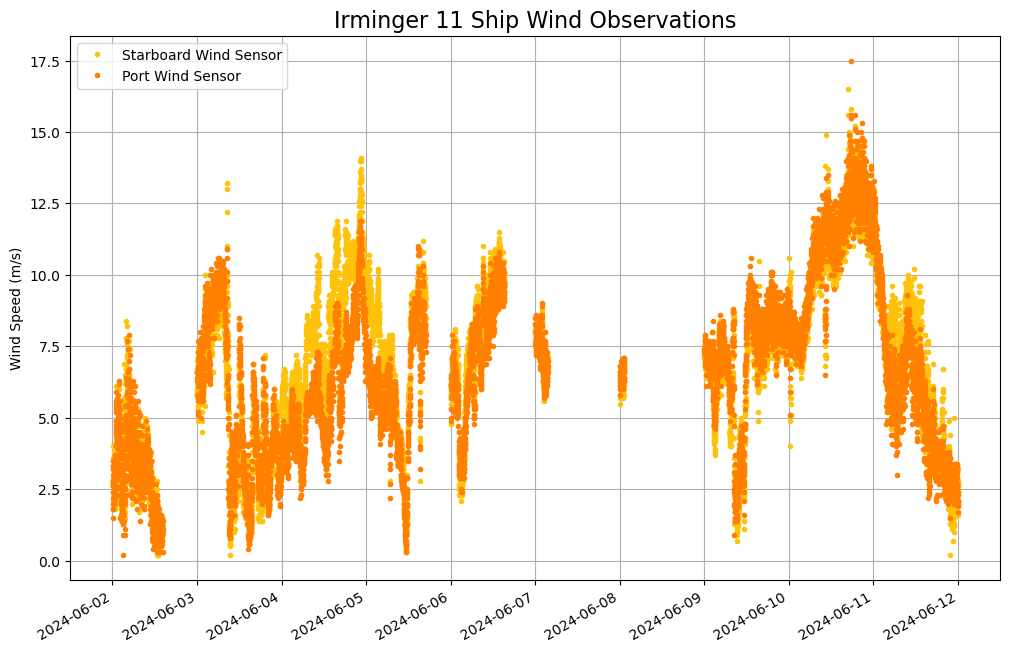

In [7]:
# Plot a timeseries of the ship observations
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(underway["time"], underway["wind_speed_starboard"], marker=".", linestyle="", label="Starboard Wind Sensor", color=colors[2])
ax.plot(underway["time"], underway["wind_speed_port"], marker=".", linestyle="", label="Port Wind Sensor",color=colors[1])
ax.legend()
ax.set_title('Irminger 11 Ship Wind Observations', fontsize=16)
ax.set_ylabel('Wind Speed (m/s)')
ax.grid()

fig.autofmt_xdate()

## Irminger Buoy Data

In [8]:
from erddapy import ERDDAP

Next, we want to connect to the ERDDAP server which has the telemetered data. Since the data is not yet being ingested into the public-facing OOI Data Explorer, we're going to access the data via the OMS++ system. OMS is the internal operators dashboard which contains much of the same data. We will search for and download the data on the OMS++ erddap server.

In [9]:
oms = ERDDAP(
    server="https://cgsn-dashboard.whoi.edu/erddap/",
    protocol="tabledap",
)

Now that we're connected to the ERDDAP server, we want to search for the available datasets

In [10]:
search_url = oms.get_search_url(response="csv")
search = pd.read_csv(search_url)
datasets = search["Dataset ID"]
datasets

0                   allDatasets
1        AS03CPPM-BUOY-GPS-01-1
2       AS03CPPM-BUOY-IRID-01-1
3      AS03CPPM-BUOY-001-SUPERV
4      AS03CPPM-IMM-CTDPFK-01-1
                 ...           
518    GS01SUMO-NSIF-SPKIR-01-1
519      GS01SUMO-NSIF-CPM-01-1
520      GS01SUMO-NSIF-DCL-01-1
521      GS01SUMO-NSIF-DCL-02-1
522    GS01SUMO-NSIF-VELPT-01-1
Name: Dataset ID, Length: 523, dtype: object

Wow. That is a lot of datasets that are availabe for download/access via OMS++. We need to figure out which one is for our data. We'll look for the array "GI01SUMO" and the instrument "METBK" to be in the dataset name/id

In [11]:
for d in datasets:
    if "GI01SUMO" in d.upper() and "METBK" in d.upper():
        print(d)

GI01SUMO-BUOY-METBK-01-1
GI01SUMO-BUOY-METBK-02-1


We also want to find the FDCHP instrument (Direct Flux Covariance) which also measures wind speed using a three-axis sonic anemometer

In [12]:
for d in datasets:
    if "GI01SUMO" in d.upper() and "FDCHP" in d.upper():
        print(d)

GI01SUMO-BUOY-FDCHP-01-1


So the Irminger buoy has two datasets: METBK 1 and METBK 2. Additionally, during mooring turns, the _new_ buoy is deployed before the _old_ buoy is recovered. This means that there is a period of time when two buoys, and thus four wind sensors, were in the water. Combined with the ship observations, this makes for six datasets for comparison. So we want to query for the following Datasets:
* GI01SUMO-BUOY-METBK-01-1: Deployment 10 (D0010) & Deployment 11 (D0011)
* GI01SUMO-BUOY-METBK-02-1: Deployment 10 (D0010) & Deployment 11 (D0011)
* GI01SUMO-BUOY-FDCHP-01-1: Deployment 10 (D0010) & Deployment 11 (D0011)

If we just query the OMS++ ERDDAP server for a given dataset id (e.g. GI01SUMO-BUOY-METBK-01-1) that will provide us _all_ of the data for that dataset available from OMS++. However, we only want data for a given deployment number and for the times which overlap the ship observations. We can pass in constraints to the ERDDAP server to limit what data we get back. The constraints we want to use are:
* deploy_id=
* time>=
* time<=
where deploy_id is a given deployment (e.g. D0010) the times are the bounding start and end times for the data, passed in using the format "YYYY-mm-ddTHH:MM:SS".

First, get the time limits of the ship observations:

In [13]:
startTime = underway.time.min()
stopTime = underway.time.max()

Next, lets get the METBK-01-1 dataset for deployment 10:

In [14]:
# Set the constraints
oms.dataset_id = "GI01SUMO-BUOY-FDCHP-01-1"
oms.constraints = {
    "deploy_id=": "D0011",
    "time>=": '2024-06-02T00:00:01',
    "time<=": '2024-06-12T00:00:01'
}

# Convert the data to a pandas dataframe indexed by time
d11_fdchp1 = oms.to_pandas(index_col='time (UTC)', parse_dates=True)
d11_fdchp1

,feature_type_instance,latitude (degrees_north),longitude (degrees_east),crs,platform,depth (m),acceleration_x,acceleration_y,acceleration_z,avg_wind_u,...,std_w_corrected,std_wind_u,std_wind_v,std_wind_w,u_corrected,v_corrected,w_corrected,wave_motion,wind_speed,deploy_id (1)
time (UTC),,,,,,,,,,,,,,,,,,,,,
2024-06-02 00:21:58+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.49,-0.72,0.5,1.95,...,0.12,0.51,0.54,0.53,3.72,1.48,0.81,0.05,4.08,D0011
2024-06-02 01:21:58+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.49,-0.72,0.5,0.14,...,0.06,0.36,0.79,0.57,3.42,-0.53,0.99,0.04,3.60,D0011
2024-06-02 02:21:58+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.49,-0.72,0.5,0.91,...,0.11,0.48,0.71,0.51,3.80,0.28,0.98,0.05,3.93,D0011
2024-06-02 03:21:58+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.49,-0.72,0.5,1.22,...,0.23,0.65,1.94,1.54,-0.30,1.36,0.07,0.04,1.40,D0011
2024-06-02 04:21:58+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.49,-0.72,0.5,2.05,...,0.39,0.81,1.11,0.86,-2.12,2.57,-0.16,0.06,3.34,D0011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-11 19:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.02,-0.03,1.0,-1.37,...,0.16,1.78,1.66,0.38,3.12,0.31,0.21,2.22,3.14,D0011
2024-06-11 20:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.02,-0.03,1.0,-0.47,...,0.10,1.47,1.42,0.33,1.98,0.88,0.15,1.97,2.17,D0011
2024-06-11 21:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.02,-0.03,1.0,-0.95,...,0.08,1.21,1.21,0.31,1.60,1.14,0.14,2.05,1.97,D0011


In [15]:
# Now lets get the rest of the datasets
oms.dataset_id = "GI01SUMO-BUOY-METBK-01-1"
oms.constraints = {
    "deploy_id=": "D0010",
    "time>=": '2024-06-10T00:00:00',
    "time<=": '2024-06-11T07:00:00'
}


d10_metbk1 = oms.to_pandas(index_col='time (UTC)', parse_dates=True)
d10_metbk1

,latitude (degrees_north),longitude (degrees_east),crs,feature_type_instance,platform,air_temperature (degrees_Celsius),barometric_pressure (mbar),eastward_wind_velocity (m s-1),longwave_irradiance (W m-2),northward_wind_velocity (m s-1),precipitation_level (mm),relative_humidity (percent),sea_surface_conductivity (S m-1),sea_surface_temperature (degrees_Celsius),shortwave_irradiance (W m-2),deploy_id (1),psu (PSU),rho (kg m-3)
time (UTC),,,,,,,,,,,,,,,,,,
2024-06-10 00:01:36+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.953,1017.63,NaN,344.8,NaN,16.91,96.028,3.5085,6.905,8.5,D0010,34.876306,1027.336798
2024-06-10 00:02:42+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.968,1017.63,NaN,345.0,NaN,16.92,96.035,3.5086,6.908,8.3,D0010,34.874363,1027.334854
2024-06-10 00:03:46+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.968,1017.84,-7.48,344.7,0.34,16.93,96.028,3.5086,6.907,8.3,D0010,34.875379,1027.335792
2024-06-10 00:04:51+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.946,1017.84,-7.56,345.0,-1.11,16.90,96.035,3.5085,6.905,8.1,D0010,34.876306,1027.336798
2024-06-10 00:05:56+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.961,1017.70,-6.35,345.0,-0.66,16.91,96.028,3.5087,6.908,8.2,D0010,34.875468,1027.335725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-11 06:54:36+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.587,1004.05,-1.30,344.9,2.97,19.92,96.051,3.4667,6.489,59.1,D0010,34.835787,1027.361197
2024-06-11 06:55:41+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.565,1004.05,-0.49,345.0,3.61,19.91,96.043,3.4667,6.489,62.8,D0010,34.835787,1027.361197
2024-06-11 06:56:45+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.602,1003.98,-1.20,345.5,3.58,19.92,96.051,3.4667,6.489,66.0,D0010,34.835787,1027.361197


In [16]:
oms.dataset_id = "GI01SUMO-BUOY-METBK-01-1"
oms.constraints = {
    "deploy_id=": "D0011",
    "time>=": '2024-06-10T00:00:00',
    "time<=": '2024-06-11T07:00:00'
}

d11_metbk1 = oms.to_pandas(index_col='time (UTC)', parse_dates=True)
d11_metbk1

,latitude (degrees_north),longitude (degrees_east),crs,feature_type_instance,platform,air_temperature (degrees_Celsius),barometric_pressure (mbar),eastward_wind_velocity (m s-1),longwave_irradiance (W m-2),northward_wind_velocity (m s-1),precipitation_level (mm),relative_humidity (percent),sea_surface_conductivity (S m-1),sea_surface_temperature (degrees_Celsius),shortwave_irradiance (W m-2),deploy_id (1),psu (PSU),rho (kg m-3)
time (UTC),,,,,,,,,,,,,,,,,,
2024-06-10 00:00:58+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.777,1017.50,-8.07,346.1,-0.18,28.67,97.334,3.4904,6.737,7.4,D0011,34.846704,1027.336456
2024-06-10 00:02:03+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.777,1017.63,-7.62,346.2,-0.67,28.64,97.316,3.4897,6.729,7.5,D0011,34.847079,1027.337839
2024-06-10 00:03:08+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.770,1017.56,-7.21,345.6,-3.78,28.61,97.328,3.4894,6.727,7.3,D0011,34.845785,1027.337090
2024-06-10 00:04:13+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.792,1017.56,-6.96,346.2,0.08,28.59,97.328,3.4895,6.729,7.3,D0011,34.844859,1027.336088
2024-06-10 00:04:47+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.777,1017.56,-7.60,346.0,-1.07,28.67,97.316,3.4892,6.725,7.3,D0011,34.845601,1027.337216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-11 06:54:47+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.513,1003.98,0.06,346.4,3.74,35.71,97.585,3.4637,6.462,33.0,D0011,34.829865,1027.360114
2024-06-11 06:55:51+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.505,1003.84,-0.76,346.2,3.87,35.73,97.591,3.4637,6.463,35.3,D0011,34.828843,1027.359175
2024-06-11 06:56:56+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.513,1003.84,-0.80,346.5,3.92,35.72,97.591,3.4637,6.462,38.9,D0011,34.829865,1027.360114


In [17]:
oms.dataset_id = "GI01SUMO-BUOY-METBK-02-1"
oms.constraints = {
    "deploy_id=": "D0011",
    "time>=": '2024-06-10T00:00:00',
    "time<=": '2024-06-11T07:00:00'
}

d11_metbk2 = oms.to_pandas(index_col='time (UTC)', parse_dates=True)
d11_metbk2

,latitude (degrees_north),longitude (degrees_east),crs,feature_type_instance,platform,air_temperature (degrees_Celsius),barometric_pressure (mbar),eastward_wind_velocity (m s-1),longwave_irradiance (W m-2),northward_wind_velocity (m s-1),precipitation_level (mm),relative_humidity (percent),sea_surface_conductivity (S m-1),sea_surface_temperature (degrees_Celsius),shortwave_irradiance (W m-2),deploy_id (1),psu (PSU),rho (kg m-3)
time (UTC),,,,,,,,,,,,,,,,,,
2024-06-10 00:00:13+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.814,1017.43,-6.65,349.7,-2.76,26.36,96.314,3.4918,6.740,5.5,D0011,34.859187,1027.345889
2024-06-10 00:01:18+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.837,1017.43,-7.09,349.2,-0.28,26.36,96.337,3.4915,6.736,5.4,D0011,34.859931,1027.347019
2024-06-10 00:02:21+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.821,1017.56,-7.25,349.7,-1.66,26.37,96.314,3.4909,6.729,5.4,D0011,34.860400,1027.348340
2024-06-10 00:03:27+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.821,1017.56,-6.25,349.4,-2.00,26.36,96.322,3.4909,6.730,5.4,D0011,34.859382,1027.347401
2024-06-10 00:04:32+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.829,1017.43,-7.52,350.0,-1.37,26.33,96.322,3.4906,6.728,5.3,D0011,34.858088,1027.346653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-11 06:55:08+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.572,1003.91,-0.69,350.4,3.81,34.41,96.329,3.4648,6.463,31.0,D0011,34.841136,1027.368874
2024-06-11 06:56:13+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.564,1003.84,-1.19,350.0,3.75,34.41,96.329,3.4648,6.463,33.6,D0011,34.841136,1027.368874
2024-06-11 06:57:17+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.572,1003.91,-1.19,350.2,3.57,34.41,96.322,3.4648,6.463,37.5,D0011,34.841136,1027.368874


In [18]:
oms.dataset_id = "GI01SUMO-BUOY-FDCHP-01-1"
oms.constraints = {
    "deploy_id=": "D0011",
    "time>=": '2024-06-10T00:00:00',
    "time<=": '2024-06-11T07:00:00'
}

d11_fdchp1 = oms.to_pandas(index_col='time (UTC)', parse_dates=True)
d11_fdchp1

,feature_type_instance,latitude (degrees_north),longitude (degrees_east),crs,platform,depth (m),acceleration_x,acceleration_y,acceleration_z,avg_wind_u,...,std_w_corrected,std_wind_u,std_wind_v,std_wind_w,u_corrected,v_corrected,w_corrected,wave_motion,wind_speed,deploy_id (1)
time (UTC),,,,,,,,,,,,,,,,,,,,,
2024-06-10 00:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.07,-0.07,0.99,-3.36,...,0.24,1.13,1.14,0.56,1.29,7.22,0.42,1.29,7.35,D0011
2024-06-10 01:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.03,-0.04,0.99,-3.23,...,0.13,2.08,1.47,0.48,0.57,6.79,0.45,1.23,6.83,D0011
2024-06-10 02:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.03,-0.04,0.99,-2.72,...,0.08,1.93,1.41,0.42,1.18,6.39,0.45,1.16,6.52,D0011
2024-06-10 03:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.03,-0.04,0.99,-2.42,...,0.24,1.86,1.49,0.52,1.11,5.84,0.37,1.11,5.95,D0011
2024-06-10 04:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.03,-0.04,0.99,-2.65,...,0.27,2.02,1.50,0.57,3.14,5.88,0.37,1.12,6.68,D0011
2024-06-10 05:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.03,-0.04,0.99,-3.41,...,0.37,2.00,1.86,0.67,3.83,6.58,0.39,1.14,7.62,D0011
2024-06-10 06:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.03,-0.05,0.99,-3.93,...,0.71,2.30,2.26,0.93,5.03,7.32,0.15,1.18,8.88,D0011
2024-06-10 07:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.03,-0.05,0.99,-3.83,...,0.36,2.35,1.61,0.63,4.18,7.41,0.63,1.29,8.53,D0011
2024-06-10 08:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.04,-0.06,0.99,-4.11,...,0.17,2.40,1.78,0.60,5.27,7.73,0.57,1.35,9.37,D0011


Before we plot we need to calculate the wind speed from our METBK1 and METBK2 eastward and northward vectors.

$$
\|{U}\| = \sqrt{u^{2} + v^{2}}
$$

Remember where $\|{U}\|$ is the magnitude of the wind speed, $u$ is the eastward vector wind speed, and $v$ is the northward vector wind speed. So we can go ahead and calculate ttha

Note: FDCHP will provide wind speed instead of the vectors so we will not need to calculatitt:

In [19]:
wspd_METBK1_D10 = np.sqrt(d10_metbk1["northward_wind_velocity (m s-1)"]**2 + d10_metbk1["eastward_wind_velocity (m s-1)"]**2)
wspd_METBK1_D10

time (UTC)
2024-06-10 00:01:36+00:00         NaN
2024-06-10 00:02:42+00:00         NaN
2024-06-10 00:03:46+00:00    7.487723
2024-06-10 00:04:51+00:00    7.641054
2024-06-10 00:05:56+00:00    6.384207
                               ...   
2024-06-11 06:54:36+00:00    3.242052
2024-06-11 06:55:41+00:00    3.643103
2024-06-11 06:56:45+00:00    3.775765
2024-06-11 06:57:50+00:00    4.215033
2024-06-11 06:58:55+00:00    3.971347
Length: 1798, dtype: float64

In [20]:
wspd_METBK1_D11 = np.sqrt(d11_metbk1["northward_wind_velocity (m s-1)"]**2 + d11_metbk1["eastward_wind_velocity (m s-1)"]**2)
wspd_METBK1_D11

time (UTC)
2024-06-10 00:00:58+00:00    8.072007
2024-06-10 00:02:03+00:00    7.649399
2024-06-10 00:03:08+00:00    8.140792
2024-06-10 00:04:13+00:00    6.960460
2024-06-10 00:04:47+00:00    7.674953
                               ...   
2024-06-11 06:54:47+00:00    3.740481
2024-06-11 06:55:51+00:00    3.943919
2024-06-11 06:56:56+00:00    4.000800
2024-06-11 06:58:00+00:00    4.202059
2024-06-11 06:59:04+00:00    4.289674
Length: 1859, dtype: float64

In [21]:
wspd_METBK2_D11 = np.sqrt(d11_metbk2["northward_wind_velocity (m s-1)"]**2 + d11_metbk2["eastward_wind_velocity (m s-1)"]**2)
wspd_METBK2_D11

time (UTC)
2024-06-10 00:00:13+00:00    7.200007
2024-06-10 00:01:18+00:00    7.095527
2024-06-10 00:02:21+00:00    7.437614
2024-06-10 00:03:27+00:00    6.562202
2024-06-10 00:04:32+00:00    7.643775
                               ...   
2024-06-11 06:55:08+00:00    3.871976
2024-06-11 06:56:13+00:00    3.934285
2024-06-11 06:57:17+00:00    3.763110
2024-06-11 06:58:21+00:00    4.382442
2024-06-11 06:59:26+00:00    4.212944
Length: 1860, dtype: float64

In [22]:
# Add the calculated results
d10_metbk1['wspd_METBK1_D10'] = wspd_METBK1_D10
d11_metbk1['wspd_METBK1_D11'] = wspd_METBK1_D11
d11_metbk2['wspd_METBK2_D11'] = wspd_METBK2_D11

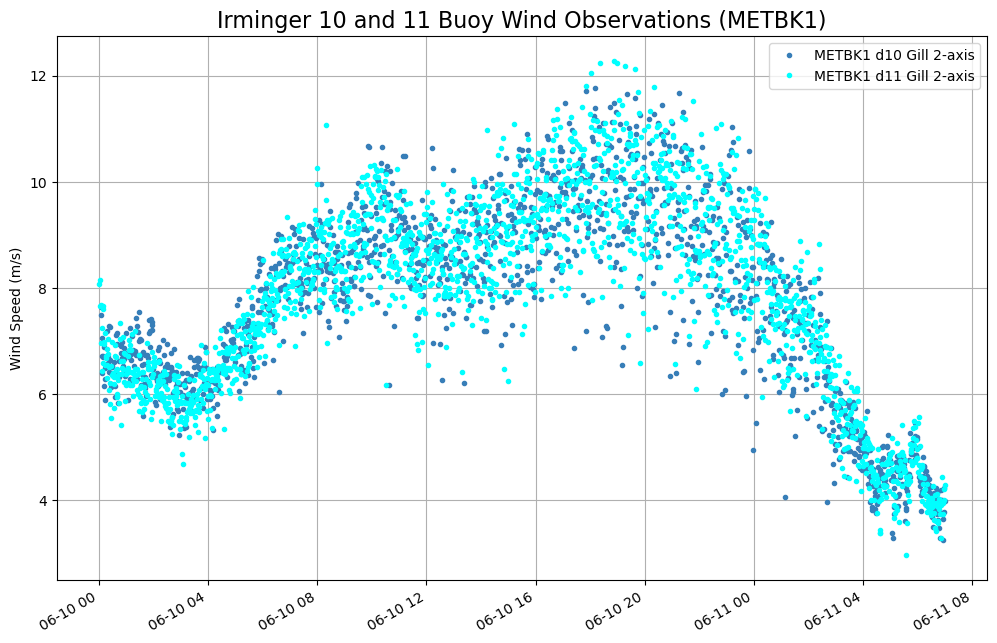

In [23]:
# Plot some comparison time series figures here (Use same colore for the whole notebook)
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(d10_metbk1.index, d10_metbk1["wspd_METBK1_D10"], marker=".", linestyle="", label="METBK1 d10 Gill 2-axis",color=colors[0])
ax.plot(d11_metbk1.index, d11_metbk1["wspd_METBK1_D11"], marker=".", linestyle="", label="METBK1 d11 Gill 2-axis",color=colors[3])

ax.legend()
ax.set_title('Irminger 10 and 11 Buoy Wind Observations (METBK1)', fontsize=16)
ax.set_ylabel('Wind Speed (m/s)')
ax.grid()

fig.autofmt_xdate()

In [24]:
#examine the dataframe
d11_fdchp1

,feature_type_instance,latitude (degrees_north),longitude (degrees_east),crs,platform,depth (m),acceleration_x,acceleration_y,acceleration_z,avg_wind_u,...,std_w_corrected,std_wind_u,std_wind_v,std_wind_w,u_corrected,v_corrected,w_corrected,wave_motion,wind_speed,deploy_id (1)
time (UTC),,,,,,,,,,,,,,,,,,,,,
2024-06-10 00:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.07,-0.07,0.99,-3.36,...,0.24,1.13,1.14,0.56,1.29,7.22,0.42,1.29,7.35,D0011
2024-06-10 01:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.03,-0.04,0.99,-3.23,...,0.13,2.08,1.47,0.48,0.57,6.79,0.45,1.23,6.83,D0011
2024-06-10 02:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.03,-0.04,0.99,-2.72,...,0.08,1.93,1.41,0.42,1.18,6.39,0.45,1.16,6.52,D0011
2024-06-10 03:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.03,-0.04,0.99,-2.42,...,0.24,1.86,1.49,0.52,1.11,5.84,0.37,1.11,5.95,D0011
2024-06-10 04:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.03,-0.04,0.99,-2.65,...,0.27,2.02,1.50,0.57,3.14,5.88,0.37,1.12,6.68,D0011
2024-06-10 05:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.03,-0.04,0.99,-3.41,...,0.37,2.00,1.86,0.67,3.83,6.58,0.39,1.14,7.62,D0011
2024-06-10 06:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.03,-0.05,0.99,-3.93,...,0.71,2.30,2.26,0.93,5.03,7.32,0.15,1.18,8.88,D0011
2024-06-10 07:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.03,-0.05,0.99,-3.83,...,0.36,2.35,1.61,0.63,4.18,7.41,0.63,1.29,8.53,D0011
2024-06-10 08:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.04,-0.06,0.99,-4.11,...,0.17,2.40,1.78,0.60,5.27,7.73,0.57,1.35,9.37,D0011


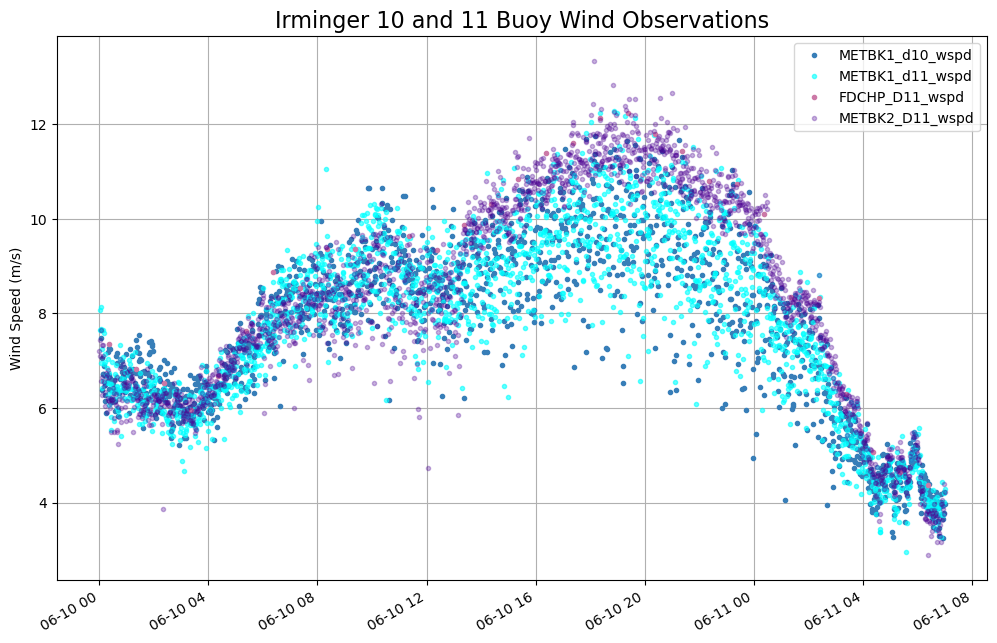

In [25]:
# Plot with all of our buoy data
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(d10_metbk1.index, d10_metbk1["wspd_METBK1_D10"], marker=".", linestyle="", label="METBK1_d10_wspd",color=colors[0])
ax.plot(d11_metbk1.index, d11_metbk1["wspd_METBK1_D11"], marker=".", linestyle="", label="METBK1_d11_wspd", color=colors[3], alpha=0.6,)
ax.plot(d11_fdchp1.index, d11_fdchp1["wind_speed"], marker=".", linestyle="", label="FDCHP_D11_wspd", color=colors[4])
ax.plot(d11_metbk2.index, d11_metbk2["wspd_METBK2_D11"], marker=".", linestyle="", label="METBK2_D11_wspd", color=colors[5], alpha = 0.3)

ax.legend()
ax.set_title('Irminger 10 and 11 Buoy Wind Observations', fontsize=16)
ax.set_ylabel('Wind Speed (m/s)')
ax.grid()

fig.autofmt_xdate()

---
### Adjust the data
One complicating factor in making an comparisons between the ship and buoy wind data is that the ship data is measured from the ship mast which, on the Armstrong, is at 17.9 m height. In comparison, the buoy MET wind sensors are mounted on the mast of the buoy. The buoy deck sits 45 cm above the water line, while the wind sensors and FDCHP are mounted 540 cm above the buoy deck. So we need to correct for the height differences between the sensors on the Armstrong and the buoys. We do this by defining a function based on the COARE (Coupled Ocean-Atmosphere Response Experiment) 3.5 flux algorithms.

In [26]:
# We first need to calculate the 10-meter wind speeds U10 and the friction-velocity u* (ustar)
def dragNC35(z: Union[int, float], U: npt.NDArray[float]) -> Tuple[npt.NDArray[float], npt.NDArray[float]]:
    """
    Calculate 10 meter winds and u* winds using COARE 3.5 algorithm
    
    Parameters
    ----------
    z: float
        The height of the wind sensor in meters
    U: float
        The measured wind speed by the wind sensor

    Returns
    -------
    U10: float
        The 10 meter winds
    Ustar: float
        The friction velocity
    """

    # Define constants
    wstr = 0.2/1.2
    ug = 0.2
    von = 0.4
    visc = 1.45E-5
    umax = 19
    a1 = 0.0017
    a2 = -0.005
    charnold = 0.011
    rnn = 1/9

    # Run the COARE 3.5 algorithm
    # Initialize values
    ut = np.sqrt(U*U + ug*ug)
    us = 0.035*ut
    charn=a1*ut + a2
    mask = (charn > umax)
    charn[mask] = a1*umax+a2
    # Iterate 10 times, updating with each successive pass
    i=0
    while i<10:
        z0 = visc/us*rnn + charn*us*us/9.8
        us = ut*von/np.log(z/z0)
        u10 = ut + us/von*np.log(10/z)
        # Update the charn variable
        mask = (u10 > umax)
        charn[mask] = a1*umax + a2
        charn[~mask] = a1*u10[~mask] + a2
        # Calculate ustar
        ustar = us
        # Calculate 10m winds
        U10 = ut + us/von*np.log(10/z)
        # Update counter
        i = i + 1

    return U10, ustar

# Next, we write a function which uses the u* values to adjust the heights
def adjust_height(wspd: npt.NDArray[float], ustar: npt.NDArray[float], z: Union[int, float], z0: Union[int, float]) -> npt.NDArray[float]:
    """
    Adjust the height of a wind sensor from height z to height z0
    
    Parameters
    ----------
    wspd: numpy.array[float]
        An array of observed wind speeds at height z
    ustar: numpy.array[float]
        An array of ustar values for the associated wspd at height
        z
    z: int | float
        Height at which the winds were observed in meters
    z0: int | float
        Height to adjust the observed wind speeds to in meters

    Returns
    -------
    adjusted: numpy.array[float]
        An array of the observed wind speeds adjusted from height z to height z0
    """

    correction = (ustar/0.4)*np.log(z0/z)
    adjusted = wspd + correction

    return adjusted

In [27]:
# Calculate the U10 and ustar 
U10, ustar = dragNC35(17.9, underway["wind_speed_starboard"].values) # z = 17.9

# Add the ustar to the underway data
underway["friction_velocity_starboard"] = (["time"], ustar)
underway["friction_velocity_starboard"].attrs = {
    'standard_name': 'friction_velocity',
    'long_name': 'Friction Velocity - Starboard',
    'units': 'm s-1',
    'comment': ('Friction velocity is a reference wind velocity that relates the Reynold\'s stress with the density. It is '
                'applied to motion near the ground where the shearing stress is assumed to be independent of height and '
                'proportional to the square of the mean velocity.')
}

# Repeat for the port sensor
U10, ustar = dragNC35(17.9, underway["wind_speed_port"].values)

# Add the ustar to the underway data
underway["friction_velocity_port"] = (["time"], ustar)
underway["friction_velocity_port"].attrs = {
    'standard_name': 'friction_velocity',
    'long_name': 'Friction Velocity - Port',
    'units': 'm s-1',
    'comment': ('Friction velocity is a reference wind velocity that relates the Reynold\'s stress with the density. It is '
                'applied to motion near the ground where the shearing stress is assumed to be independent of height and '
                'proportional to the square of the mean velocity.')
}

In [28]:
# Calculate the adjusted wind speed
wspd_starboard = underway["wind_speed_starboard"]
ustar_starboard = underway["friction_velocity_starboard"]
underway["adj_wind_speed_starboard"] = adjust_height(wspd_starboard, ustar, 17.9, 5.85)
underway["adj_wind_speed_starboard"]

# Repeat for the port sensor
wspd_port = underway["wind_speed_port"]
ustar_port = underway["friction_velocity_port"]
underway["adj_wind_speed_port"] = adjust_height(wspd_port, ustar, 17.9, 5.85)
underway["adj_wind_speed_port"]

<xarray.DataArray 'adj_wind_speed_port' (time: 10272)>
array([2.20196642, 2.5714212 , 2.47905569, ..., 1.92495065, 1.83264063,
       1.74034868])
Coordinates:
  * time     (time) datetime64[ns] 2024-06-02T00:00:54.506000 ... 2024-06-11T...

In [29]:
os.getcwd()

'C:\\Users\\aaron.wickware\\Documents\\PEP2024'

In [30]:
!pip install h5netcdf

Now we have data that are directly comparable to each other. I would recommend saving your different datasets as new datasets locally so you don't have to go through the different data access steps. Now we are ready to begin analysis!

In [31]:
# We are going to slice our 
underway.sel(time = slice('2024-06-10 00:00:00','2024-06-11 07:00:00'))

<xarray.Dataset>
Dimensions:                            (time: 1860)
Coordinates:
  * time                               (time) datetime64[ns] 2024-06-10T00:00...
Data variables: (12/40)
    latitude                           (time) float64 59.94 59.94 ... 59.95
    longitude                          (time) float64 -39.47 -39.47 ... -39.53
    ship_speed                         (time) float64 1.07 1.0 ... 4.25 4.16
    heading                            (time) float64 35.46 36.06 ... 141.4
    DPS_COG                            (time) float64 37.52 8.62 ... 143.0 157.5
    speed_over_ground                  (time) float64 0.65 0.71 ... 3.99 4.46
    ...                                 ...
    em122                              (time) float64 nan nan nan ... nan nan
    EM710                              (time) float64 nan nan nan ... nan nan
    friction_velocity_starboard        (time) float64 0.3304 0.2953 ... 0.1417
    friction_velocity_port             (time) float64 0.2996 0.2658 ... 0.1512
    adj_wind_speed_starboard           (time) float64 8.962 8.257 ... 4.75 4.477
    adj_wind_speed_port                (time) float64 8.262 7.557 ... 5.05 4.777

In [32]:
underway_june10_june11 = underway.sel(time = slice('2024-06-10 00:00:00','2024-06-11 07:00:00'))

In [33]:
# Examine our adjusted data and plot
underway_june10_june11

<xarray.Dataset>
Dimensions:                            (time: 1860)
Coordinates:
  * time                               (time) datetime64[ns] 2024-06-10T00:00...
Data variables: (12/40)
    latitude                           (time) float64 59.94 59.94 ... 59.95
    longitude                          (time) float64 -39.47 -39.47 ... -39.53
    ship_speed                         (time) float64 1.07 1.0 ... 4.25 4.16
    heading                            (time) float64 35.46 36.06 ... 141.4
    DPS_COG                            (time) float64 37.52 8.62 ... 143.0 157.5
    speed_over_ground                  (time) float64 0.65 0.71 ... 3.99 4.46
    ...                                 ...
    em122                              (time) float64 nan nan nan ... nan nan
    EM710                              (time) float64 nan nan nan ... nan nan
    friction_velocity_starboard        (time) float64 0.3304 0.2953 ... 0.1417
    friction_velocity_port             (time) float64 0.2996 0.2658 ... 0.1512
    adj_wind_speed_starboard           (time) float64 8.962 8.257 ... 4.75 4.477
    adj_wind_speed_port                (time) float64 8.262 7.557 ... 5.05 4.777

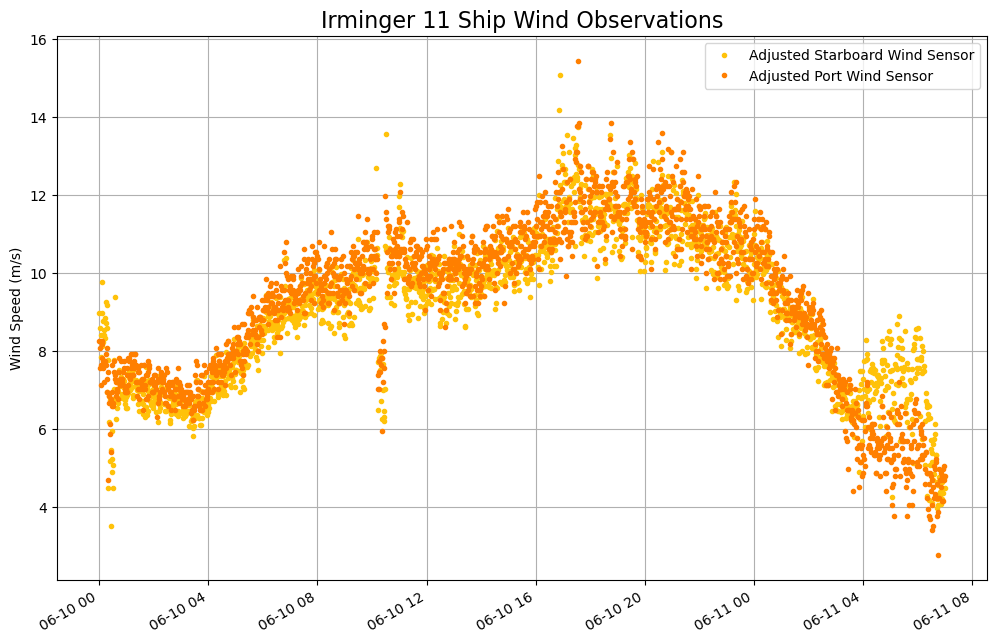

In [34]:
# Now let's plot our time series
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(underway_june10_june11["time"], underway_june10_june11["adj_wind_speed_starboard"], marker=".", linestyle="", label="Adjusted Starboard Wind Sensor",color=colors[2])
ax.plot(underway_june10_june11["time"], underway_june10_june11["adj_wind_speed_port"], marker=".", linestyle="", label="Adjusted Port Wind Sensor",color=colors[1])

ax.legend()
ax.set_title('Irminger 11 Ship Wind Observations', fontsize=16)
ax.set_ylabel('Wind Speed (m/s)')
ax.grid()

fig.autofmt_xdate()

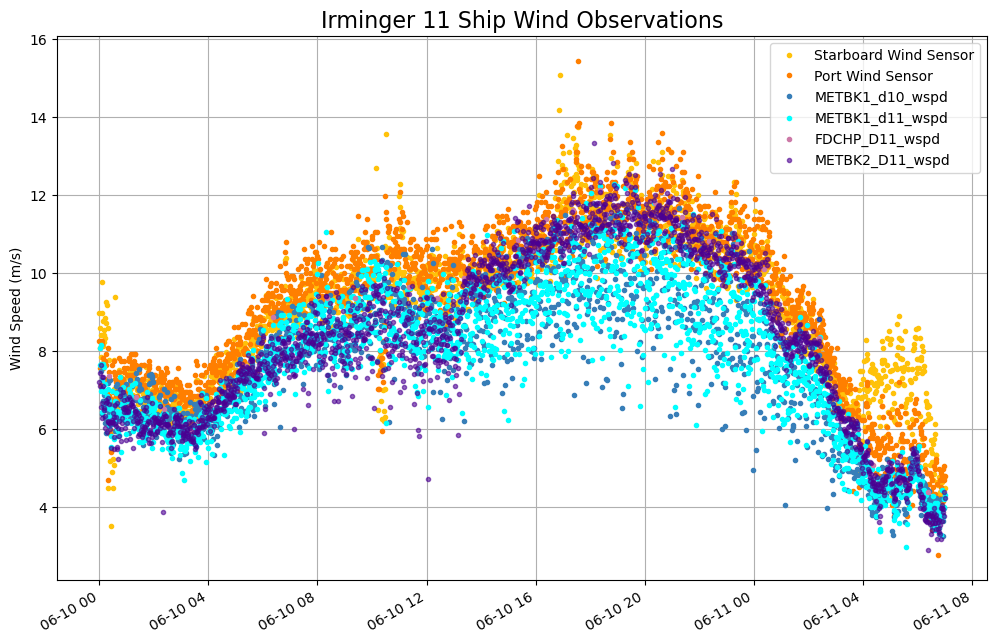

In [35]:
# Plot a timeseries of the ship observations
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(underway_june10_june11["time"], underway_june10_june11["adj_wind_speed_starboard"], marker=".", linestyle="", label="Starboard Wind Sensor",color=colors[2])
ax.plot(underway_june10_june11["time"], underway_june10_june11["adj_wind_speed_port"], marker=".", linestyle="", label="Port Wind Sensor",color=colors[1])
ax.plot(d10_metbk1.index, d10_metbk1["wspd_METBK1_D10"], marker=".", linestyle="", label="METBK1_d10_wspd", color=colors[0])
ax.plot(d11_metbk1.index, d11_metbk1["wspd_METBK1_D11"], marker=".", linestyle="", label="METBK1_d11_wspd", color=colors[3])
ax.plot(d11_fdchp1.index, d11_fdchp1["wind_speed"], marker=".", linestyle="", label="FDCHP_D11_wspd", color=colors[4])
ax.plot(d11_metbk2.index, d11_metbk2["wspd_METBK2_D11"], marker=".", linestyle="", label="METBK2_D11_wspd", color=colors[5], alpha = 0.6)


ax.legend()
ax.set_title('Irminger 11 Ship Wind Observations', fontsize=16)
ax.set_ylabel('Wind Speed (m/s)')
ax.grid()

fig.autofmt_xdate()

Now we have a time series of all of data, how does it look? 

If your graph looks good then your done, but if you have some loose points we can try and take the mean of our data to try and clean up the graph and declutter a little bit.

In [36]:
d11_metbk1

,latitude (degrees_north),longitude (degrees_east),crs,feature_type_instance,platform,air_temperature (degrees_Celsius),barometric_pressure (mbar),eastward_wind_velocity (m s-1),longwave_irradiance (W m-2),northward_wind_velocity (m s-1),precipitation_level (mm),relative_humidity (percent),sea_surface_conductivity (S m-1),sea_surface_temperature (degrees_Celsius),shortwave_irradiance (W m-2),deploy_id (1),psu (PSU),rho (kg m-3),wspd_METBK1_D11
time (UTC),,,,,,,,,,,,,,,,,,,
2024-06-10 00:00:58+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.777,1017.50,-8.07,346.1,-0.18,28.67,97.334,3.4904,6.737,7.4,D0011,34.846704,1027.336456,8.072007
2024-06-10 00:02:03+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.777,1017.63,-7.62,346.2,-0.67,28.64,97.316,3.4897,6.729,7.5,D0011,34.847079,1027.337839,7.649399
2024-06-10 00:03:08+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.770,1017.56,-7.21,345.6,-3.78,28.61,97.328,3.4894,6.727,7.3,D0011,34.845785,1027.337090,8.140792
2024-06-10 00:04:13+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.792,1017.56,-6.96,346.2,0.08,28.59,97.328,3.4895,6.729,7.3,D0011,34.844859,1027.336088,6.960460
2024-06-10 00:04:47+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.777,1017.56,-7.60,346.0,-1.07,28.67,97.316,3.4892,6.725,7.3,D0011,34.845601,1027.337216,7.674953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-11 06:54:47+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.513,1003.98,0.06,346.4,3.74,35.71,97.585,3.4637,6.462,33.0,D0011,34.829865,1027.360114,3.740481
2024-06-11 06:55:51+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.505,1003.84,-0.76,346.2,3.87,35.73,97.591,3.4637,6.463,35.3,D0011,34.828843,1027.359175,3.943919
2024-06-11 06:56:56+00:00,59.998,-39.481,-2147483647,NaN,-2147483647,6.513,1003.84,-0.80,346.5,3.92,35.72,97.591,3.4637,6.462,38.9,D0011,34.829865,1027.360114,4.000800


Note: if there are floats you will not be able resample the data or run the mean or std. functions, to fix this we want to drop all the qualitative columns in our data set: *Deployment Identification*.

FDCHP will also have *Featured Deployment Name* so we will drop that one aswell.

In [37]:
d11_fdchp = d11_fdchp1.drop(columns='deploy_id (1)')
d11_fdchp

,feature_type_instance,latitude (degrees_north),longitude (degrees_east),crs,platform,depth (m),acceleration_x,acceleration_y,acceleration_z,avg_wind_u,...,std_v_corrected,std_w_corrected,std_wind_u,std_wind_v,std_wind_w,u_corrected,v_corrected,w_corrected,wave_motion,wind_speed
time (UTC),,,,,,,,,,,,,,,,,,,,,
2024-06-10 00:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.07,-0.07,0.99,-3.36,...,0.31,0.24,1.13,1.14,0.56,1.29,7.22,0.42,1.29,7.35
2024-06-10 01:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.03,-0.04,0.99,-3.23,...,0.35,0.13,2.08,1.47,0.48,0.57,6.79,0.45,1.23,6.83
2024-06-10 02:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.03,-0.04,0.99,-2.72,...,0.26,0.08,1.93,1.41,0.42,1.18,6.39,0.45,1.16,6.52
2024-06-10 03:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.03,-0.04,0.99,-2.42,...,0.38,0.24,1.86,1.49,0.52,1.11,5.84,0.37,1.11,5.95
2024-06-10 04:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.03,-0.04,0.99,-2.65,...,0.27,0.27,2.02,1.50,0.57,3.14,5.88,0.37,1.12,6.68
2024-06-10 05:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.03,-0.04,0.99,-3.41,...,0.43,0.37,2.00,1.86,0.67,3.83,6.58,0.39,1.14,7.62
2024-06-10 06:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.03,-0.05,0.99,-3.93,...,0.80,0.71,2.30,2.26,0.93,5.03,7.32,0.15,1.18,8.88
2024-06-10 07:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.03,-0.05,0.99,-3.83,...,0.35,0.36,2.35,1.61,0.63,4.18,7.41,0.63,1.29,8.53
2024-06-10 08:21:57+00:00,gi01sumo,59.998,-39.481,-2147483647,-2147483647,-4.81,0.04,-0.06,0.99,-4.11,...,0.34,0.17,2.40,1.78,0.60,5.27,7.73,0.57,1.35,9.37


In [38]:
d11_fdchp = d11_fdchp.drop(columns='feature_type_instance')

In [39]:
underway_june10_june11

<xarray.Dataset>
Dimensions:                            (time: 1860)
Coordinates:
  * time                               (time) datetime64[ns] 2024-06-10T00:00...
Data variables: (12/40)
    latitude                           (time) float64 59.94 59.94 ... 59.95
    longitude                          (time) float64 -39.47 -39.47 ... -39.53
    ship_speed                         (time) float64 1.07 1.0 ... 4.25 4.16
    heading                            (time) float64 35.46 36.06 ... 141.4
    DPS_COG                            (time) float64 37.52 8.62 ... 143.0 157.5
    speed_over_ground                  (time) float64 0.65 0.71 ... 3.99 4.46
    ...                                 ...
    em122                              (time) float64 nan nan nan ... nan nan
    EM710                              (time) float64 nan nan nan ... nan nan
    friction_velocity_starboard        (time) float64 0.3304 0.2953 ... 0.1417
    friction_velocity_port             (time) float64 0.2996 0.2658 ... 0.1512
    adj_wind_speed_starboard           (time) float64 8.962 8.257 ... 4.75 4.477
    adj_wind_speed_port                (time) float64 8.262 7.557 ... 5.05 4.777

In [40]:
# Assign mean variable, assign std. variable.
d11_metbk1_mean = d11_metbk1.drop(columns='deploy_id (1)').resample('1H').mean()
d10_metbk1_mean = d10_metbk1.drop(columns='deploy_id (1)').resample('1H').mean()
d11_metbk2_mean = d11_metbk2.drop(columns='deploy_id (1)').resample('1H').mean()

C:\Users\aaron.wickware\AppData\Local\Temp\ipykernel_17332\2101115071.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  d11_metbk1_mean = d11_metbk1.drop(columns='deploy_id (1)').resample('1H').mean()
C:\Users\aaron.wickware\AppData\Local\Temp\ipykernel_17332\2101115071.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  d10_metbk1_mean = d10_metbk1.drop(columns='deploy_id (1)').resample('1H').mean()
C:\Users\aaron.wickware\AppData\Local\Temp\ipykernel_17332\2101115071.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  d11_metbk2_mean = d11_metbk2.drop(columns='deploy_id (1)').resample('1H').mean()


In [41]:
d11_metbk1_std = d11_metbk1.drop(columns='deploy_id (1)').resample('1H').std()
d10_metbk1_std = d10_metbk1.drop(columns='deploy_id (1)').resample('1H').std()
d11_metbk2_std = d11_metbk2.drop(columns='deploy_id (1)').resample('1H').std()

C:\Users\aaron.wickware\AppData\Local\Temp\ipykernel_17332\126817641.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  d11_metbk1_std = d11_metbk1.drop(columns='deploy_id (1)').resample('1H').std()
C:\Users\aaron.wickware\AppData\Local\Temp\ipykernel_17332\126817641.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  d10_metbk1_std = d10_metbk1.drop(columns='deploy_id (1)').resample('1H').std()
C:\Users\aaron.wickware\AppData\Local\Temp\ipykernel_17332\126817641.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  d11_metbk2_std = d11_metbk2.drop(columns='deploy_id (1)').resample('1H').std()


In [42]:
d11_fdchp.columns
d11_fdchp_mean=d11_fdchp.drop(columns='dcl_date_time_string (1)').resample('1H').mean()

C:\Users\aaron.wickware\AppData\Local\Temp\ipykernel_17332\269297510.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  d11_fdchp_mean=d11_fdchp.drop(columns='dcl_date_time_string (1)').resample('1H').mean()


In [43]:
d11_fdchp_std=d11_fdchp.drop(columns='dcl_date_time_string (1)').resample('1H').std()

C:\Users\aaron.wickware\AppData\Local\Temp\ipykernel_17332\178761960.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  d11_fdchp_std=d11_fdchp.drop(columns='dcl_date_time_string (1)').resample('1H').std()


In [44]:
underway_june10_june11_mean=underway_june10_june11.resample(time = '1H').mean()

C:\Users\aaron.wickware\AppData\Local\miniconda3\Lib\site-packages\xarray\core\groupby.py:508: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(


In [45]:
underway_june10_june11_std=underway_june10_june11.resample(time = '1H').std()

C:\Users\aaron.wickware\AppData\Local\miniconda3\Lib\site-packages\xarray\core\groupby.py:508: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(


In [46]:
underway_june10_june11_mean["time"]

<xarray.DataArray 'time' (time: 31)>
array(['2024-06-10T00:00:00.000000000', '2024-06-10T01:00:00.000000000',
       '2024-06-10T02:00:00.000000000', '2024-06-10T03:00:00.000000000',
       '2024-06-10T04:00:00.000000000', '2024-06-10T05:00:00.000000000',
       '2024-06-10T06:00:00.000000000', '2024-06-10T07:00:00.000000000',
       '2024-06-10T08:00:00.000000000', '2024-06-10T09:00:00.000000000',
       '2024-06-10T10:00:00.000000000', '2024-06-10T11:00:00.000000000',
       '2024-06-10T12:00:00.000000000', '2024-06-10T13:00:00.000000000',
       '2024-06-10T14:00:00.000000000', '2024-06-10T15:00:00.000000000',
       '2024-06-10T16:00:00.000000000', '2024-06-10T17:00:00.000000000',
       '2024-06-10T18:00:00.000000000', '2024-06-10T19:00:00.000000000',
       '2024-06-10T20:00:00.000000000', '2024-06-10T21:00:00.000000000',
       '2024-06-10T22:00:00.000000000', '2024-06-10T23:00:00.000000000',
       '2024-06-11T00:00:00.000000000', '2024-06-11T01:00:00.000000000',
       '2024-06-11T02:00:00.000000000', '2024-06-11T03:00:00.000000000',
       '2024-06-11T04:00:00.000000000', '2024-06-11T05:00:00.000000000',
       '2024-06-11T06:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2024-06-10 ... 2024-06-11T06:00:00

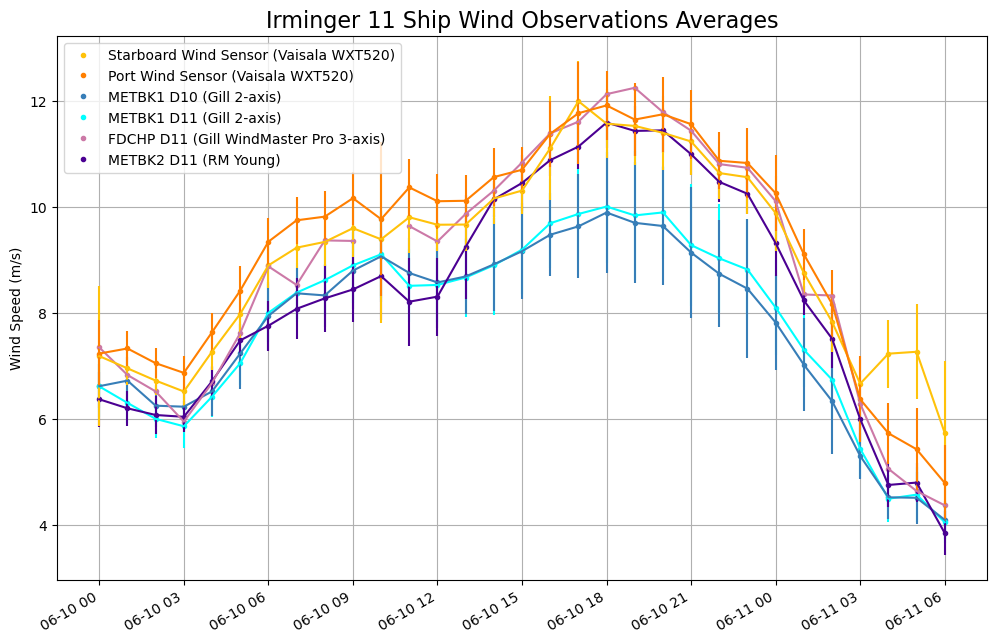

In [54]:
## Plot a timeseries of the ship observations averages (Red/Green colorblind friendly)
fig, ax = plt.subplots(figsize=(12, 8))


ax.plot(underway_june10_june11_mean["time"], underway_june10_june11_mean["adj_wind_speed_starboard"], marker=".", linestyle="", label="Starboard Wind Sensor (Vaisala WXT520)", color=colors[2])
ax.plot(underway_june10_june11_mean["time"], underway_june10_june11_mean["adj_wind_speed_port"], marker=".", linestyle="", label="Port Wind Sensor (Vaisala WXT520)",color=colors[1])
ax.plot(d10_metbk1_mean.index, d10_metbk1_mean["wspd_METBK1_D10"], marker=".", linestyle="", label="METBK1 D10 (Gill 2-axis)",color=colors[0])
ax.plot(d11_metbk1_mean.index, d11_metbk1_mean["wspd_METBK1_D11"], marker=".", linestyle="", label="METBK1 D11 (Gill 2-axis)", color=colors[3])
ax.plot(d11_fdchp_mean.index, d11_fdchp_mean["wind_speed"], marker=".", linestyle="", label="FDCHP D11 (Gill WindMaster Pro 3-axis)", color=colors[4])
ax.plot(d11_metbk2_mean.index, d11_metbk2_mean["wspd_METBK2_D11"], marker=".", linestyle="", label="METBK2 D11 (RM Young)", color=colors[5])

# Plot the Error
ax.errorbar(x=d11_metbk1_mean.index,y=d11_metbk1_mean["wspd_METBK1_D11"] , yerr=d11_metbk1_std["wspd_METBK1_D11"],color=colors[3])
ax.errorbar(x=d10_metbk1_mean.index,y=d10_metbk1_mean["wspd_METBK1_D10"] , yerr=d10_metbk1_std["wspd_METBK1_D10"], color=colors[0])
ax.errorbar(x=d11_metbk2_mean.index,y=d11_metbk2_mean["wspd_METBK2_D11"] , yerr=d11_metbk2_std["wspd_METBK2_D11"], color=colors[5])
ax.errorbar(x=d11_fdchp_mean.index,y=d11_fdchp_mean["wind_speed"] , yerr=d11_fdchp_std["wind_speed"], color=colors[4])
ax.errorbar(x=underway_june10_june11_mean['time'].data, y=underway_june10_june11_mean["adj_wind_speed_starboard"].data , yerr=underway_june10_june11_std["adj_wind_speed_starboard"].data, color=colors[2])
ax.errorbar(x=underway_june10_june11_mean['time'].data, y=underway_june10_june11_mean["adj_wind_speed_port"].data , yerr=underway_june10_june11_std["adj_wind_speed_port"].data, color=colors[1])

ax.legend()
ax.set_title('Irminger 11 Ship Wind Observations Averages', fontsize=16)
ax.set_ylabel('Wind Speed (m/s)')
ax.grid()

fig.autofmt_xdate()


In [66]:
file_path = path.abspath("/Users/aaron.wickware/Documents/PEP2024/Ship_buoy_comparisons.csv")

len(file_path)

67

In [67]:
underway_adj_wspd = underway_june10_june11_mean[['adj_wind_speed_starboard', 'adj_wind_speed_port']].to_dataframe()

In [68]:
underway_adj_wspd

,adj_wind_speed_starboard,adj_wind_speed_port
time,,
2024-06-10 00:00:00,7.186400,7.234733
2024-06-10 01:00:00,6.955703,7.330703
2024-06-10 02:00:00,6.724526,7.052859
2024-06-10 03:00:00,6.518797,6.870464
2024-06-10 04:00:00,7.270750,7.637417
2024-06-10 05:00:00,7.982521,8.422521
2024-06-10 06:00:00,8.898982,9.345648
2024-06-10 07:00:00,9.232387,9.749054
2024-06-10 08:00:00,9.341786,9.818453


In [69]:
underway_adj_wspd.to_csv(file_path)